In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from scipy.signal import butter, filtfilt

def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


In [17]:
data_path = '/data2/spike_sorting/neuropixels_choi'
filename = ["/set1/20141202_all_es", "/set2/20150924_1_e", "/set3/20150601_all_s", "/set4/20150924_1_GT"]

In [18]:
index = 0
ground_truth_path = data_path+filename[index]+'_gtTimes.mat'

In [19]:
# 근데 prob파일에 129번째 채널이 없네?


## Merge

In [20]:
initial_sample_point = 45_000_000
width = 1_500_000
max_iter = 10
n_channel = 129
n_unit = 7 if index != 2 else 8 # set2는 예외적으로 unit 8개다.
frequency = 25_000
my_seed = 42
seed_assign(my_seed)

In [21]:
# 3,125,000 샘플만 쓸래. # 현실시간 125s = 3,125,000 / 25000Hz

In [22]:
all_waveforms = []
for i in range(max_iter):
    start_index = initial_sample_point + i * width + 1  # 현재 반복에서 시작 인덱스 계산
    end_index = initial_sample_point + (i + 1) * width  # 현재 반복에서 끝 인덱스 계산
    
    current_dataset = f"{data_path}{filename[index]}_start{start_index}_end{end_index}.mat"
    mat1 = io.loadmat(current_dataset)
    all_waveforms.append(mat1['raw_data'])
    print(mat1.keys())
merged_waveform = np.concatenate(all_waveforms, axis=1)
print(merged_waveform.shape)
print(mat1['raw_data'].dtype)


dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
dict_keys(['__header__', '__version__', '__globals__', 'raw_data'])
(129, 15000000)
float64


In [23]:
ground_truth_path = data_path+filename[index]+'_gtTimes.mat'

mat1 = io.loadmat(ground_truth_path)
spike_times_int_all_units = []
for i in range(n_unit):
    temp = mat1['gtTimes'][0][i][:,0]
    temp = temp[(initial_sample_point + 1 < temp) & (temp < initial_sample_point + max_iter * width)]
    spike_times_int_all_units.append(temp)
    print('unit', i, '스파이크 튄 gttime', temp.shape)

spike_chans_int_all_units = []
for i in range(n_unit):
    spike_chans_int_all_units.append(mat1['gtChans'][0][i][:,0])
    print('unit', i,'연관 ch', mat1['gtChans'][0][i][:,0].shape)
    
print('유닛 개수', mat1['gtTimes'][0].shape)

unit 0 스파이크 튄 gttime (3157,)
unit 1 스파이크 튄 gttime (863,)
unit 2 스파이크 튄 gttime (959,)
unit 3 스파이크 튄 gttime (87,)
unit 4 스파이크 튄 gttime (8569,)
unit 5 스파이크 튄 gttime (1330,)
unit 6 스파이크 튄 gttime (4769,)
unit 0 연관 ch (12,)
unit 1 연관 ch (12,)
unit 2 연관 ch (14,)
unit 3 연관 ch (8,)
unit 4 연관 ch (11,)
unit 5 연관 ch (10,)
unit 6 연관 ch (10,)
유닛 개수 (7,)


In [24]:
print(len(merged_waveform))
print(merged_waveform[0].shape)

129
(15000000,)


In [25]:
print(len(spike_times_int_all_units))
print(spike_times_int_all_units[0].shape) # 0번째 unit의 spike time

7
(3157,)


In [26]:
total_spike = 0
for i in range(n_unit):
    total_spike += spike_times_int_all_units[i].shape[0]
print('모든 채널의 모든 스파이크 개수 합', total_spike)

모든 채널의 모든 스파이크 개수 합 19734


In [27]:
print('총 유닛',len(spike_chans_int_all_units))
for i in spike_chans_int_all_units:
    print(i)
# 유닛별 잘 나오는 channel

총 유닛 7
[ 75  76  77  69  70  74 107 108 109 101 102 103]
[ 73  75  76  70  74 105 106 107 108 102 103 104]
[ 75  76  77  68  69  70 107 108 109 100 101 102 103  78]
[ 1 15 16 33 34 47 48 49]
[ 92  93  94  84  85  86 124 125 126 116 117]
[ 81  65  66 111 112 113 114 128  97  98]
[ 79  65  66  67 111 112 113  97  98  99]


In [28]:
# merged_waveform = merged_waveform/256

In [29]:
np.save(f"{data_path}{filename[index]}_merged_{initial_sample_point+1}_{initial_sample_point+max_iter*width}.npy", merged_waveform)

bandpass해보기. matlab에서 하고왔지만 여기서 하면 조금 더 깎네

(129, 15000000)


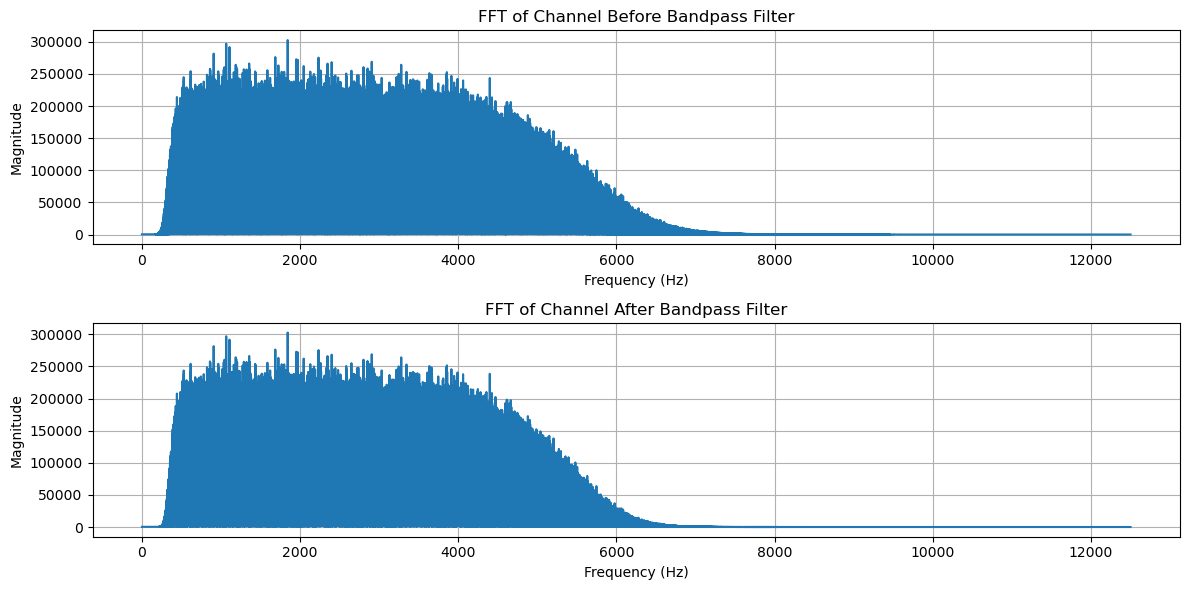

In [30]:
# Bandpass filter 함수
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Butterworth 필터 설계
    b, a = butter(order, [low, high], btype='band')
    
    # 필터링 적용
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# bandpass filter 적용
lowcut = 300.0  # 필터의 낮은 주파수 (Hz)
highcut = 6000.0  # 필터의 높은 주파수 (Hz)

for i in range(merged_waveform.shape[0]):
    merged_waveform[i] = bandpass_filter(merged_waveform[i], lowcut, highcut, frequency)
print(merged_waveform.shape)

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# 한 채널의 데이터 선택 (예: 첫 번째 채널)
channel_data_before = merged_waveform[0]

# FFT 계산 (샘플링 주파수에 따라 나눠야 합니다)
sampling_rate = frequency  # 샘플링 주파수 (Hz)
n = len(channel_data_before)
frequencies = fftfreq(n, 1 / sampling_rate)

# 필터링 전의 주파수 분석
fft_before = fft(channel_data_before)
fft_magnitude_before = np.abs(fft_before)

# bandpass 필터 적용 후
channel_data_after = bandpass_filter(channel_data_before, lowcut, highcut, sampling_rate)

# 필터링 후의 주파수 분석
fft_after = fft(channel_data_after)
fft_magnitude_after = np.abs(fft_after)

# 플로팅
plt.figure(figsize=(12, 6))

# 필터링 전
plt.subplot(2, 1, 1)
plt.plot(frequencies[:n // 2], fft_magnitude_before[:n // 2])  # 양의 주파수만 표시
plt.title("FFT of Channel Before Bandpass Filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)

# 필터링 후
plt.subplot(2, 1, 2)
plt.plot(frequencies[:n // 2], fft_magnitude_after[:n // 2])  # 양의 주파수만 표시
plt.title("FFT of Channel After Bandpass Filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)

plt.tight_layout()
plt.show()
